In [23]:
# General data handling/io
import datetime
import pandas as pd
import numpy as np
import pickle

# Viz libs
import matplotlib.pyplot as plt 

# ML libs
from sklearn.model_selection import (train_test_split,
                                     RepeatedStratifiedKFold,
                                     cross_val_score)

from sklearn.feature_selection import RFECV

from sklearn.metrics import (classification_report,
                             confusion_matrix, 
                             plot_roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              AdaBoostClassifier, 
                              RandomForestClassifier)

# Importing libs for SMOTE technique
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Turning off future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [24]:
def base_data():
    
    return pd.read_csv('processed_data.csv')

In [25]:
def select_features(df):
    
    features = [f for f in df.columns if f != 'serious_delinquencies_in_past_2_years']
    
    X = df[features]
    Y = df['serious_delinquencies_in_past_2_years'].values
    
    return X, Y

In [26]:
def smote_resampling(df):
    
    X, Y = select_features(df)
    
    smote = SMOTE(random_state=42)
    
    Xs, Ys = smote.fit_resample(X, Y)
    
    return Xs, Ys

In [27]:
def feature_select_recursive(X, Y, model, name):
        
    rfe = RFECV(model, cv=RepeatedStratifiedKFold(4),
              scoring='roc_auc')
    
    rfe = rfe.fit(X, Y)
    
    cols = list(X.columns)
    features = pd.Series(rfe.support_,index = cols)
    
    selected_features_rfe = features[features==True].index.tolist()
    
    print('\n')
    print('Selected Features for:', name)
    print(selected_features_rfe)
    print('\n')

    return selected_features_rfe

In [28]:
def model_selection():
    
    df = base_data()
    
    models = list()
    
    # Try these models first
    models.append(('Logistic', LogisticRegression())) 
    models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('Random Forest', RandomForestClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    
    for name, model in models:
        
        print('\n{}'.format(name))
        print('------------------------------------------------------')
        print('------------------------------------------------------')
        
        # Split out X, Y
        X, Y = smote_resampling(df)
        
        
        if name != 'KNN':
        # Use RFECV
            features = feature_select_recursive(X, Y, model, name)
        
        # Apply the feature selection
            X = X[features]
        
        # Break out train and test sets (using 80% train 20% test)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
        
        # TODO: Pull the other metrics from the crossval 
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        
        scores = cross_val_score(model, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
        
        print('CV: {}: Mean ROC AUC: {} Std Dev: {}'.format(name, np.mean(scores).round(3),
                                                        np.std(scores).round(3)))
        
        # Fit the model to the training split
        model.fit(X_train, y_train)
        
        # Make predictions
        predictions = model.predict(X_test)
                
        print('\n Confusion Matrix:')
        print(confusion_matrix(y_test, predictions))
        
        print('\n Classification Report')
        print(classification_report(y_test, predictions))
        
        # Show the AUC Curve for the model
        plot_roc_curve(model, X_test, y_test)  
        plt.show() 
        
        print('\nWriting out {} to disk'.format(name))
        filename = 'models/{}.sav'.format(name)
        pickle.dump(model, open(filename, 'wb'))
        
        print('\n------------------------------------------------------')
        


Logistic
------------------------------------------------------
------------------------------------------------------


Selected Features for: Logistic
['age', 'monthly_revenue', 'debt_ratio', 'rated_exposure', 'composite_overdue']


CV: Logistic: Mean ROC AUC: 0.815 Std Dev: 0.005

 Confusion Matrix:
[[6040  936]
 [2665 4198]]

 Classification Report
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      6976
           1       0.82      0.61      0.70      6863

    accuracy                           0.74     13839
   macro avg       0.76      0.74      0.74     13839
weighted avg       0.76      0.74      0.74     13839



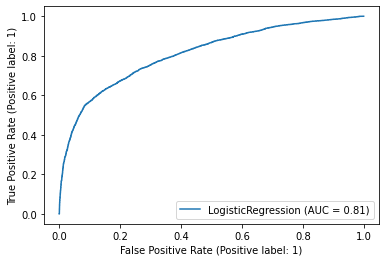


Writing out Logistic to disk

------------------------------------------------------

KNN
------------------------------------------------------
------------------------------------------------------
CV: KNN: Mean ROC AUC: 0.865 Std Dev: 0.003

 Confusion Matrix:
[[5265 1711]
 [1302 5561]]

 Classification Report
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      6976
           1       0.76      0.81      0.79      6863

    accuracy                           0.78     13839
   macro avg       0.78      0.78      0.78     13839
weighted avg       0.78      0.78      0.78     13839



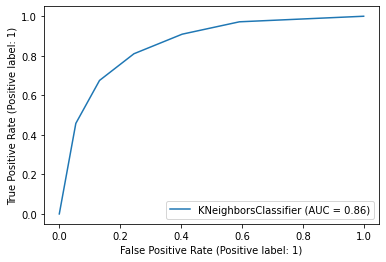


Writing out KNN to disk

------------------------------------------------------

GBC
------------------------------------------------------
------------------------------------------------------


Selected Features for: GBC
['age', 'monthly_revenue', 'debt_ratio', 'rated_exposure', 'composite_overdue']


CV: GBC: Mean ROC AUC: 0.916 Std Dev: 0.003

 Confusion Matrix:
[[6179  797]
 [1296 5567]]

 Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      6976
           1       0.87      0.81      0.84      6863

    accuracy                           0.85     13839
   macro avg       0.85      0.85      0.85     13839
weighted avg       0.85      0.85      0.85     13839



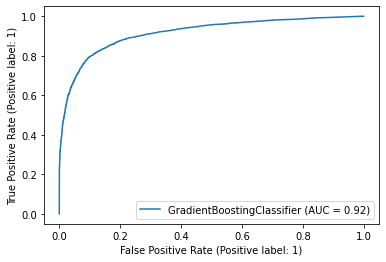


Writing out GBC to disk

------------------------------------------------------

Random Forest
------------------------------------------------------
------------------------------------------------------


Selected Features for: Random Forest
['age', 'monthly_revenue', 'debt_ratio', 'rated_exposure', 'composite_overdue']


CV: Random Forest: Mean ROC AUC: 0.939 Std Dev: 0.003

 Confusion Matrix:
[[6107  869]
 [ 899 5964]]

 Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6976
           1       0.87      0.87      0.87      6863

    accuracy                           0.87     13839
   macro avg       0.87      0.87      0.87     13839
weighted avg       0.87      0.87      0.87     13839



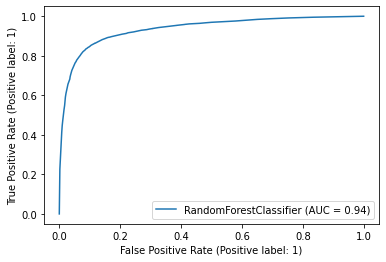


Writing out Random Forest to disk

------------------------------------------------------

CART
------------------------------------------------------
------------------------------------------------------


Selected Features for: CART
['debt_ratio', 'composite_overdue']


CV: CART: Mean ROC AUC: 0.877 Std Dev: 0.005

 Confusion Matrix:
[[6286  690]
 [1408 5455]]

 Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      6976
           1       0.89      0.79      0.84      6863

    accuracy                           0.85     13839
   macro avg       0.85      0.85      0.85     13839
weighted avg       0.85      0.85      0.85     13839



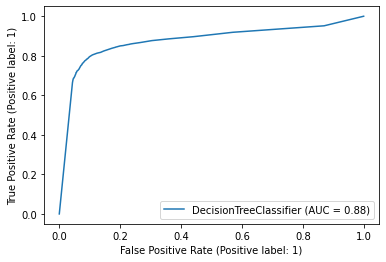


Writing out CART to disk

------------------------------------------------------


In [29]:
model_selection()